In [1]:
## Import Dependencies
import cv2
import mediapipe as mp
import time, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
actions = ['love', 'come', 'heart', 'hello', 'deny']
seq_length = 30
secs_for_action = 30

In [3]:
# MediaPipe hands model
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(
    max_num_hands=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5)

In [4]:
cap = cv2.VideoCapture(0)

In [5]:
created_time = int(time.time())
os.makedirs('dataset', exist_ok=True)

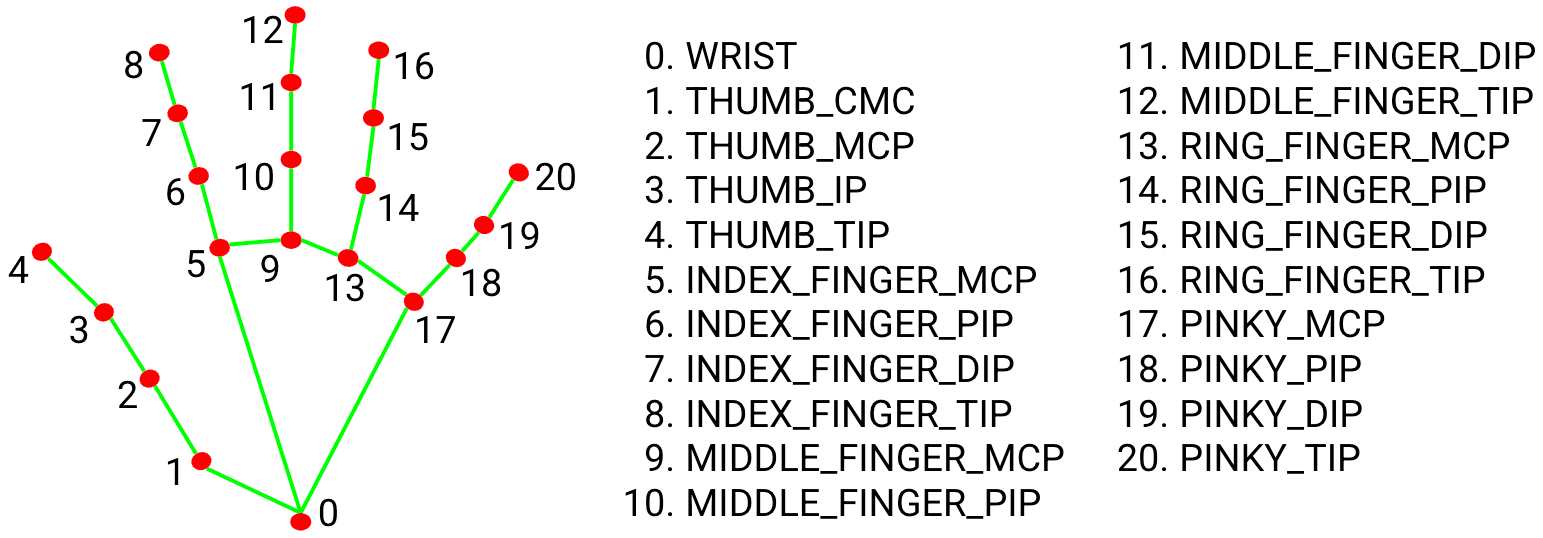
#### from https://google.github.io/mediapipe/solutions/hands.html

In [11]:
while cap.isOpened():
    for idx, action in enumerate(actions):
        data = []

        ret, img = cap.read()

        img = cv2.flip(img, 1)

        cv2.putText(img, f'Waiting for collecting {action.upper()} action...', org=(10, 30), \
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)
        cv2.imshow('img', img)
        cv2.waitKey(3000)

        start_time = time.time()

        while time.time() - start_time < secs_for_action:
            ret, img = cap.read()

            img = cv2.flip(img, 1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            result = hands.process(img)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

            if result.multi_hand_landmarks is not None:
                for res in result.multi_hand_landmarks:
                    joint = np.zeros((21, 4))
                    for j, lm in enumerate(res.landmark):
                        joint[j] = [lm.x, lm.y, lm.z, lm.visibility]

                    # Compute angles between joints
                    v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19], :3] # Parent joint
                    v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], :3] # Child joint
                    v = v2 - v1 # [20, 3]
                    # Normalize v
                    v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]

                    # Get angle using arcos of dot product
                    angle = np.arccos(np.einsum('nt,nt->n',
                        v[[0,1,2,4,5,6,8,9,10,12,13,14,16,17,18],:], 
                        v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:])) # [15,]

                    angle = np.degrees(angle) # Convert radian to degree

                    angle_label = np.array([angle], dtype=np.float32)
                    angle_label = np.append(angle_label, idx)

                    d = np.concatenate([joint.flatten(), angle_label])

                    data.append(d)

                    mp_drawing.draw_landmarks(img, res, mp_hands.HAND_CONNECTIONS)

            cv2.imshow('img', img)
            if cv2.waitKey(1) == ord('q'):
                break

        data = np.array(data)
        print(action, data.shape)
        np.save(os.path.join('dataset', f'raw_{action}_{created_time}'), data)

        # Create sequence data
        full_seq_data = []
        for seq in range(len(data) - seq_length):
            full_seq_data.append(data[seq:seq + seq_length])

        full_seq_data = np.array(full_seq_data)
        print(action, full_seq_data.shape)
        np.save(os.path.join('dataset', f'seq_{action}_{created_time}'), full_seq_data)
    break


love (534, 100)
love (504, 30, 100)
come (589, 100)
come (559, 30, 100)
heart (569, 100)
heart (539, 30, 100)
hello (569, 100)
hello (539, 30, 100)
deny (574, 100)
deny (544, 30, 100)


## check out collected data

In [6]:
import matplotlib.pyplot as plt
def isStartwith(char):
    return char.startswith('raw')
seq_filelist= list(filter(isStartwith, os.listdir('dataset')))
seq_filelist

['raw_come_1666682801.npy',
 'raw_deny_1666682801.npy',
 'raw_heart_1666682801.npy',
 'raw_hello_1666682801.npy',
 'raw_love_1666682801.npy']

In [7]:
activities= [seq_filelist[i].split('_')[1] for i in range(len(seq_filelist))]
activities

['come', 'deny', 'heart', 'hello', 'love']

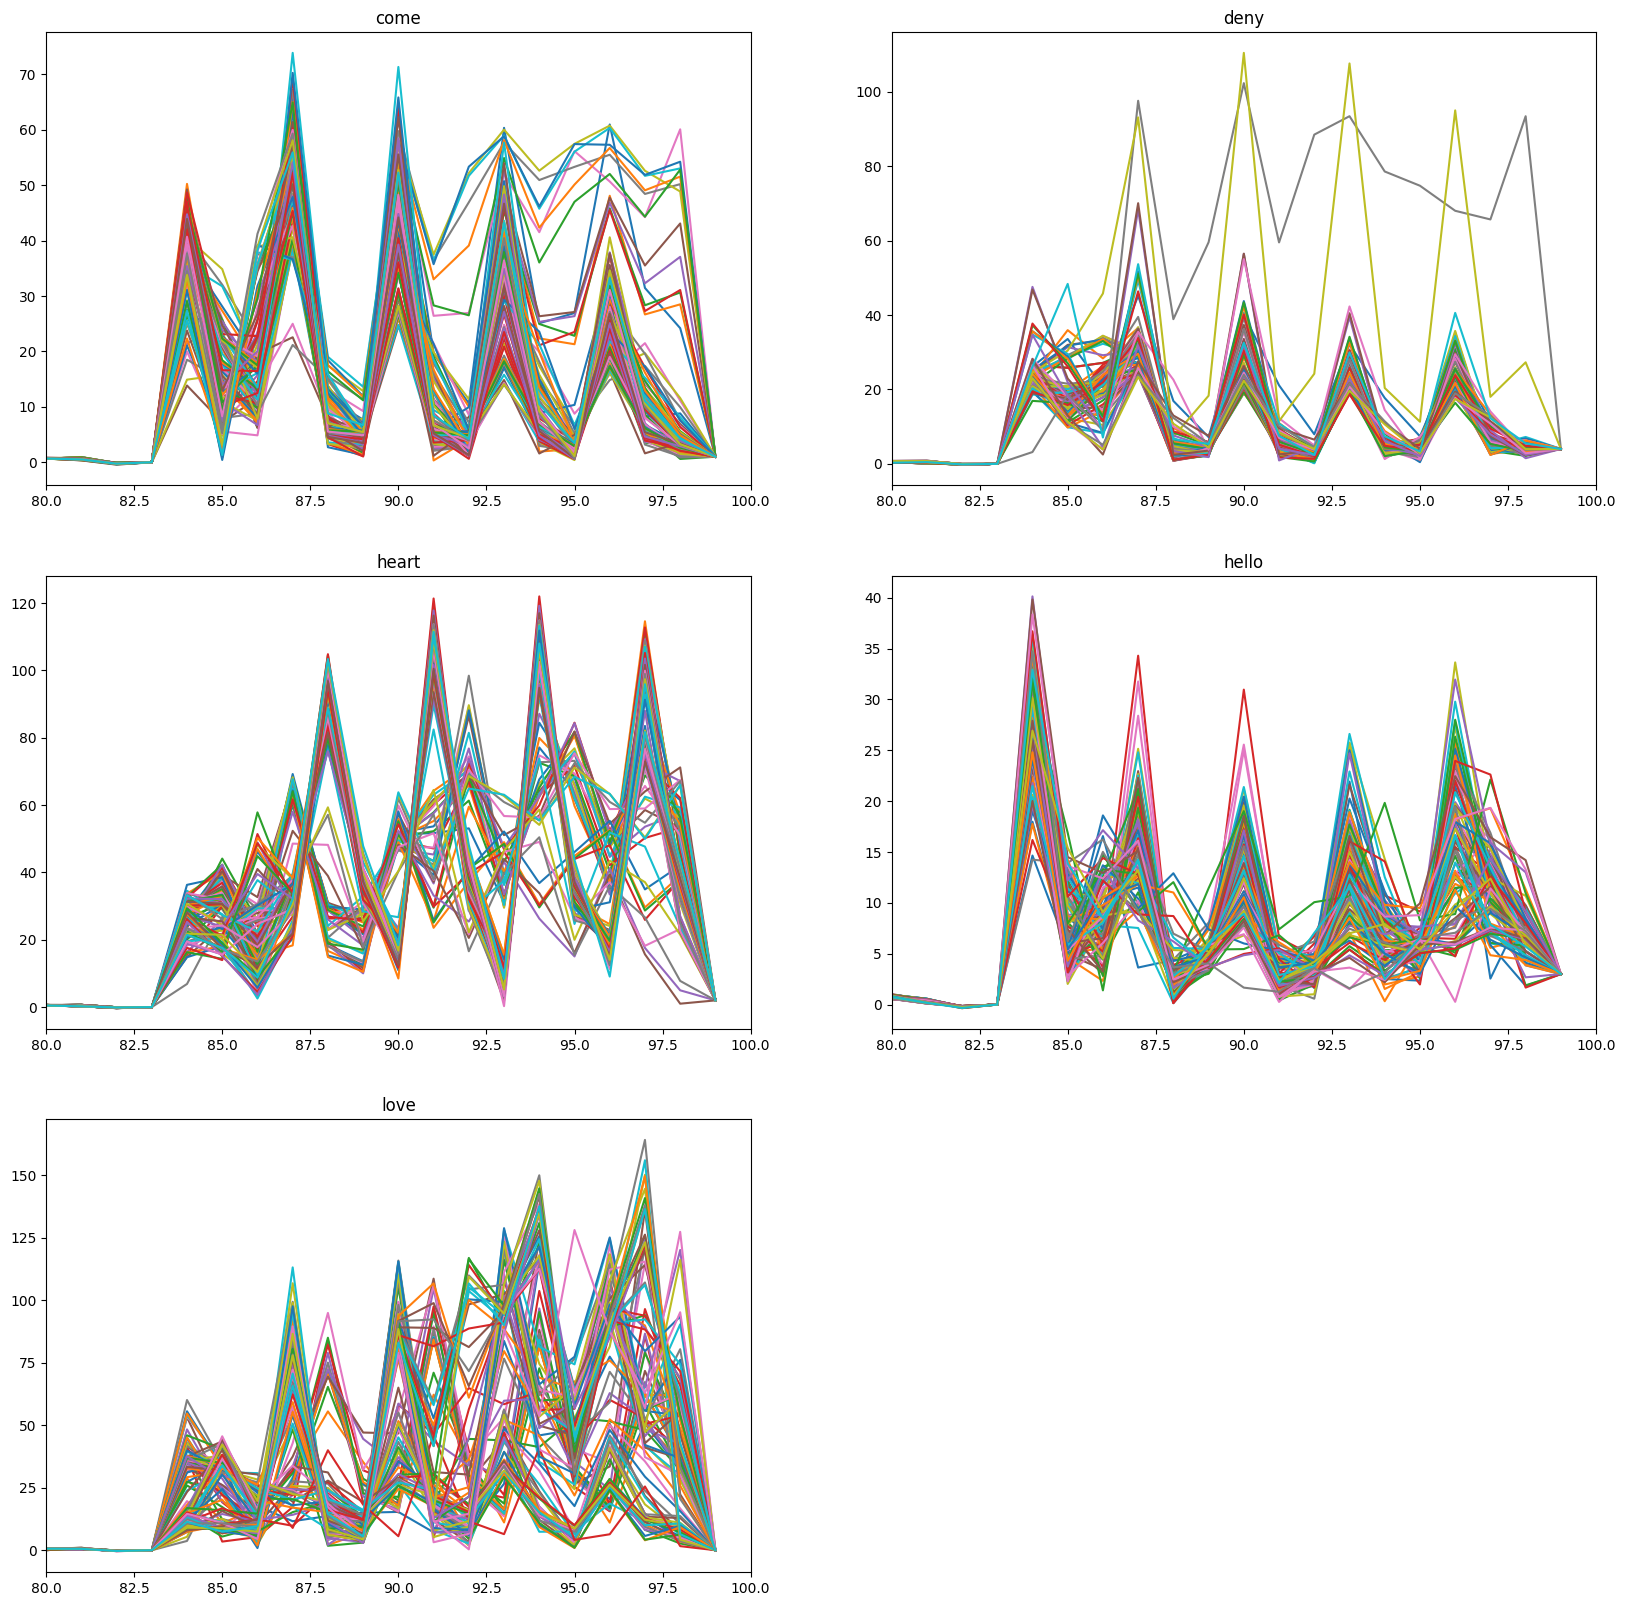

In [8]:
plt.figure(figsize=(20, 20))

for a in range(len(seq_filelist)):
    collected_data= np.load(os.path.join('dataset', seq_filelist[a]))
    plt.subplot(3, 2, a+1)
    plt.title(activities[a])
    for i in range(100):
        plt.xlim(80, 100)
        plt.plot(collected_data[i])        

In [9]:
collected_dataset= np.concatenate([np.load(os.path.join('dataset', seq_filelist[0])),
                                  np.load(os.path.join('dataset', seq_filelist[1])),
                                  np.load(os.path.join('dataset', seq_filelist[2])),
                                  np.load(os.path.join('dataset', seq_filelist[3])),
                                  np.load(os.path.join('dataset', seq_filelist[4]))], axis=0)
collected_dataset

array([[8.63750100e-01, 5.31961620e-01, 1.18694231e-06, ...,
        3.14443359e+01, 2.41933651e+01, 1.00000000e+00],
       [8.98037672e-01, 5.42836308e-01, 6.68007146e-07, ...,
        2.66701050e+01, 2.84908180e+01, 1.00000000e+00],
       [8.69180560e-01, 5.58303058e-01, 5.56034706e-07, ...,
        2.83246078e+01, 3.06363335e+01, 1.00000000e+00],
       ...,
       [7.75070310e-01, 5.87797582e-01, 1.01314549e-06, ...,
        6.32981834e+01, 4.15111122e+01, 0.00000000e+00],
       [7.74879813e-01, 5.91201305e-01, 1.03571176e-06, ...,
        6.40873718e+01, 4.69819298e+01, 0.00000000e+00],
       [7.96862185e-01, 5.93361974e-01, 1.00102307e-06, ...,
        8.47555618e+01, 6.89991913e+01, 0.00000000e+00]])

In [10]:
collected_df= pd.DataFrame()
for j in range(len(collected_dataset)):
    collected_df= pd.concat([collected_df, pd.DataFrame(collected_dataset[j]).T], axis=0)
collected_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.863750,0.531962,1.186942e-06,0.0,0.796494,0.471815,-0.049250,0.0,0.714726,0.457247,...,62.364197,19.601730,10.630959,60.334957,25.091688,26.919178,60.942425,31.444336,24.193365,1.0
0,0.898038,0.542836,6.680071e-07,0.0,0.824435,0.460061,-0.038836,0.0,0.728870,0.457589,...,49.855709,19.791250,10.013784,46.976498,22.342672,21.295277,48.081524,26.670105,28.490818,1.0
0,0.869181,0.558303,5.560347e-07,0.0,0.785216,0.478935,-0.022498,0.0,0.692586,0.479809,...,50.655464,19.061493,5.984741,45.351856,24.952976,22.812462,45.818657,28.324608,30.636333,1.0
0,0.860140,0.577536,3.899545e-07,0.0,0.780969,0.497488,-0.021937,0.0,0.685268,0.496918,...,51.605934,15.313105,4.906468,45.838730,21.104870,23.519493,45.519165,27.284166,31.077745,1.0
0,0.849979,0.603805,3.870200e-07,0.0,0.773296,0.523431,-0.022549,0.0,0.679123,0.521764,...,53.704533,15.296312,4.738495,47.439133,25.322708,26.365873,46.840508,32.291660,37.064632,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.759438,0.586429,1.045738e-06,0.0,0.759780,0.477830,-0.107339,0.0,0.719785,0.384425,...,75.781181,65.885498,72.443634,83.230347,66.821411,50.662739,82.841499,59.482193,43.867287,0.0
0,0.752528,0.600157,1.024940e-06,0.0,0.758879,0.489148,-0.110208,0.0,0.720901,0.396902,...,75.697479,68.279785,58.949734,82.365677,67.075211,46.168583,83.772346,54.362362,45.354408,0.0
0,0.775070,0.587798,1.013145e-06,0.0,0.769873,0.472886,-0.114641,0.0,0.722405,0.379687,...,75.237465,71.468399,64.170219,81.168503,70.202034,47.712975,79.557816,63.298183,41.511112,0.0
0,0.774880,0.591201,1.035712e-06,0.0,0.773137,0.472043,-0.109204,0.0,0.732090,0.375291,...,76.068832,70.235306,69.880074,83.130707,70.960426,51.716942,82.325333,64.087372,46.981930,0.0


In [11]:
activities= {
    0: 'love',
    1: 'come', 
    2: 'heart',
    3: 'hello',
    4: 'deny',
}
label= [activities[collected_dataset[a][len(collected_dataset[a])-1]] for a in range(len(collected_dataset))]
collected_df['label']= label

In [12]:
collected_df

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
0,0.863750,0.531962,1.186942e-06,0.0,0.796494,0.471815,-0.049250,0.0,0.714726,0.457247,...,19.601730,10.630959,60.334957,25.091688,26.919178,60.942425,31.444336,24.193365,1.0,come
0,0.898038,0.542836,6.680071e-07,0.0,0.824435,0.460061,-0.038836,0.0,0.728870,0.457589,...,19.791250,10.013784,46.976498,22.342672,21.295277,48.081524,26.670105,28.490818,1.0,come
0,0.869181,0.558303,5.560347e-07,0.0,0.785216,0.478935,-0.022498,0.0,0.692586,0.479809,...,19.061493,5.984741,45.351856,24.952976,22.812462,45.818657,28.324608,30.636333,1.0,come
0,0.860140,0.577536,3.899545e-07,0.0,0.780969,0.497488,-0.021937,0.0,0.685268,0.496918,...,15.313105,4.906468,45.838730,21.104870,23.519493,45.519165,27.284166,31.077745,1.0,come
0,0.849979,0.603805,3.870200e-07,0.0,0.773296,0.523431,-0.022549,0.0,0.679123,0.521764,...,15.296312,4.738495,47.439133,25.322708,26.365873,46.840508,32.291660,37.064632,1.0,come
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.759438,0.586429,1.045738e-06,0.0,0.759780,0.477830,-0.107339,0.0,0.719785,0.384425,...,65.885498,72.443634,83.230347,66.821411,50.662739,82.841499,59.482193,43.867287,0.0,love
0,0.752528,0.600157,1.024940e-06,0.0,0.758879,0.489148,-0.110208,0.0,0.720901,0.396902,...,68.279785,58.949734,82.365677,67.075211,46.168583,83.772346,54.362362,45.354408,0.0,love
0,0.775070,0.587798,1.013145e-06,0.0,0.769873,0.472886,-0.114641,0.0,0.722405,0.379687,...,71.468399,64.170219,81.168503,70.202034,47.712975,79.557816,63.298183,41.511112,0.0,love
0,0.774880,0.591201,1.035712e-06,0.0,0.773137,0.472043,-0.109204,0.0,0.732090,0.375291,...,70.235306,69.880074,83.130707,70.960426,51.716942,82.325333,64.087372,46.981930,0.0,love


In [43]:
def dist_sns(feature):
    sns.set_palette("Set1", desat=0.80)
    facetgrid= sns.FacetGrid(collected_df, hue='label', height=8, aspect=2)
    facetgrid.map(sns.histplot,feature, kde=True, stat='density', alpha=.1, kde_kws=dict(cut=3)).add_legend()

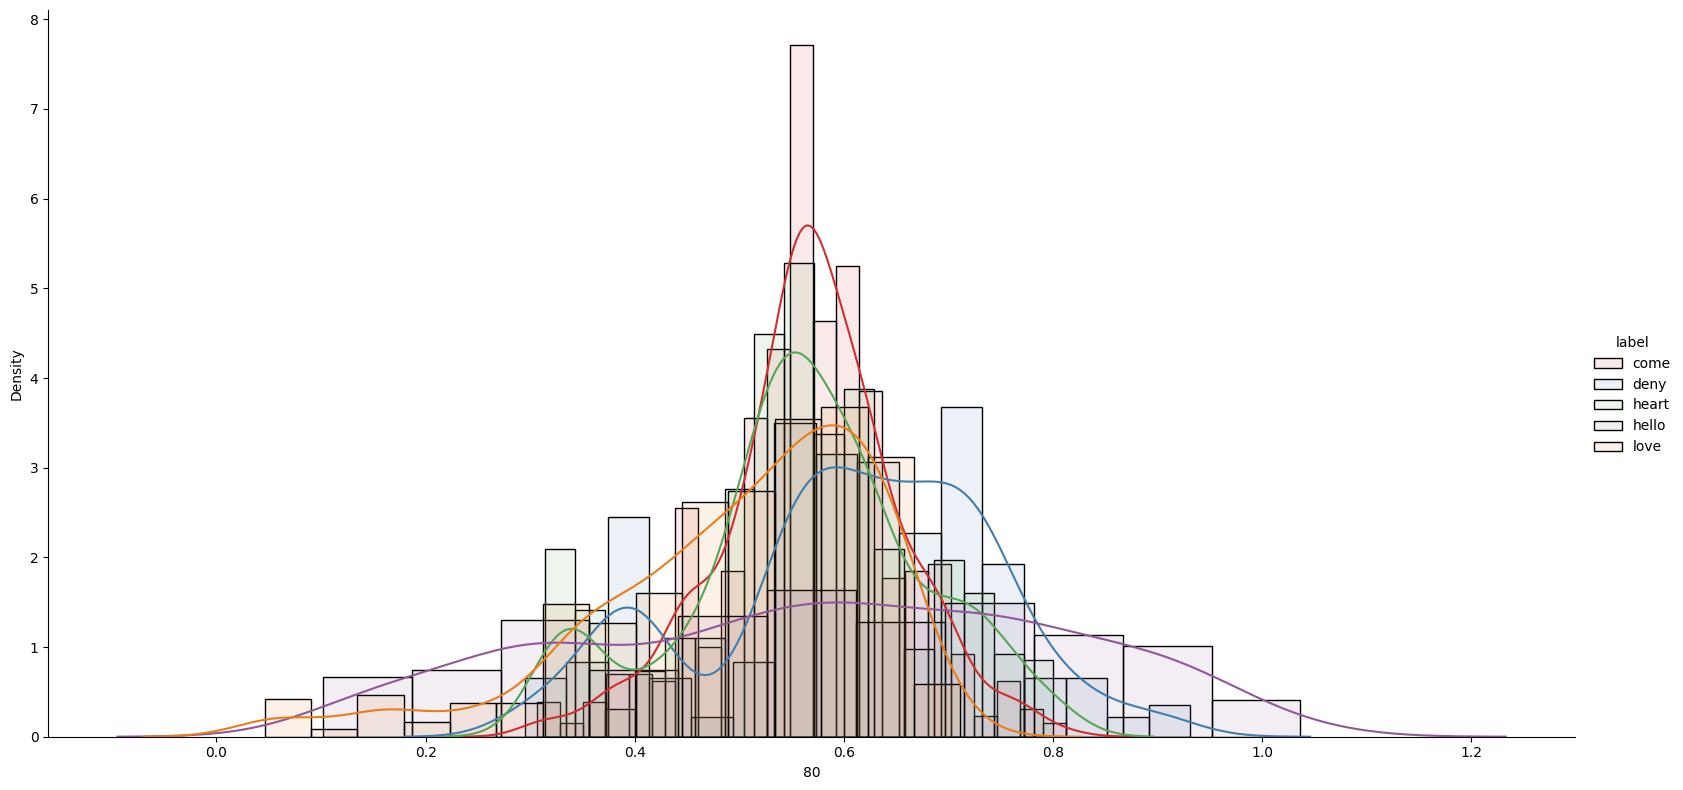

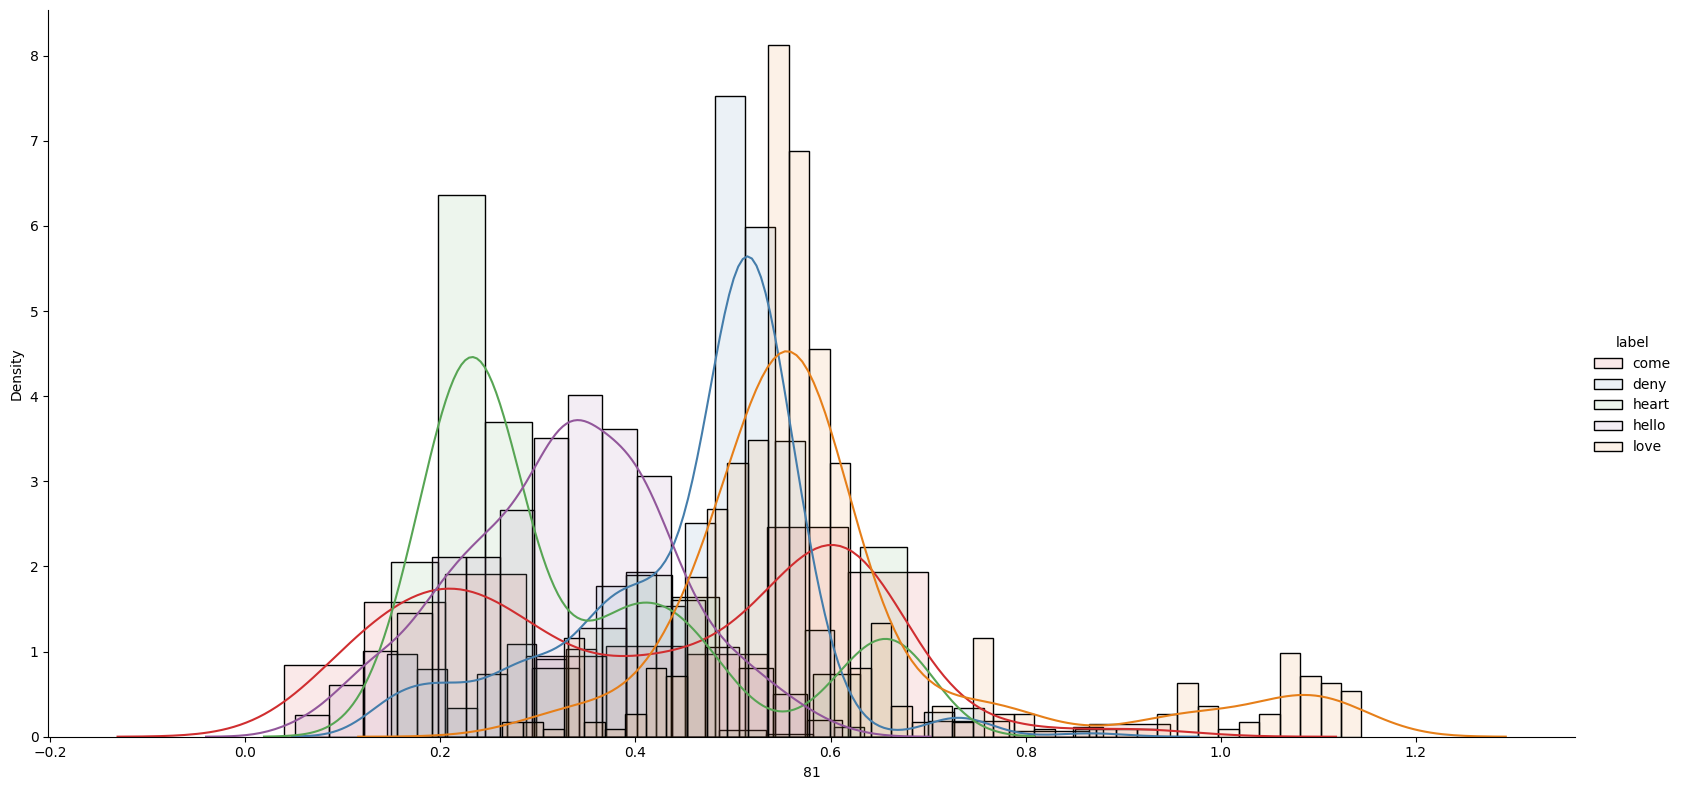

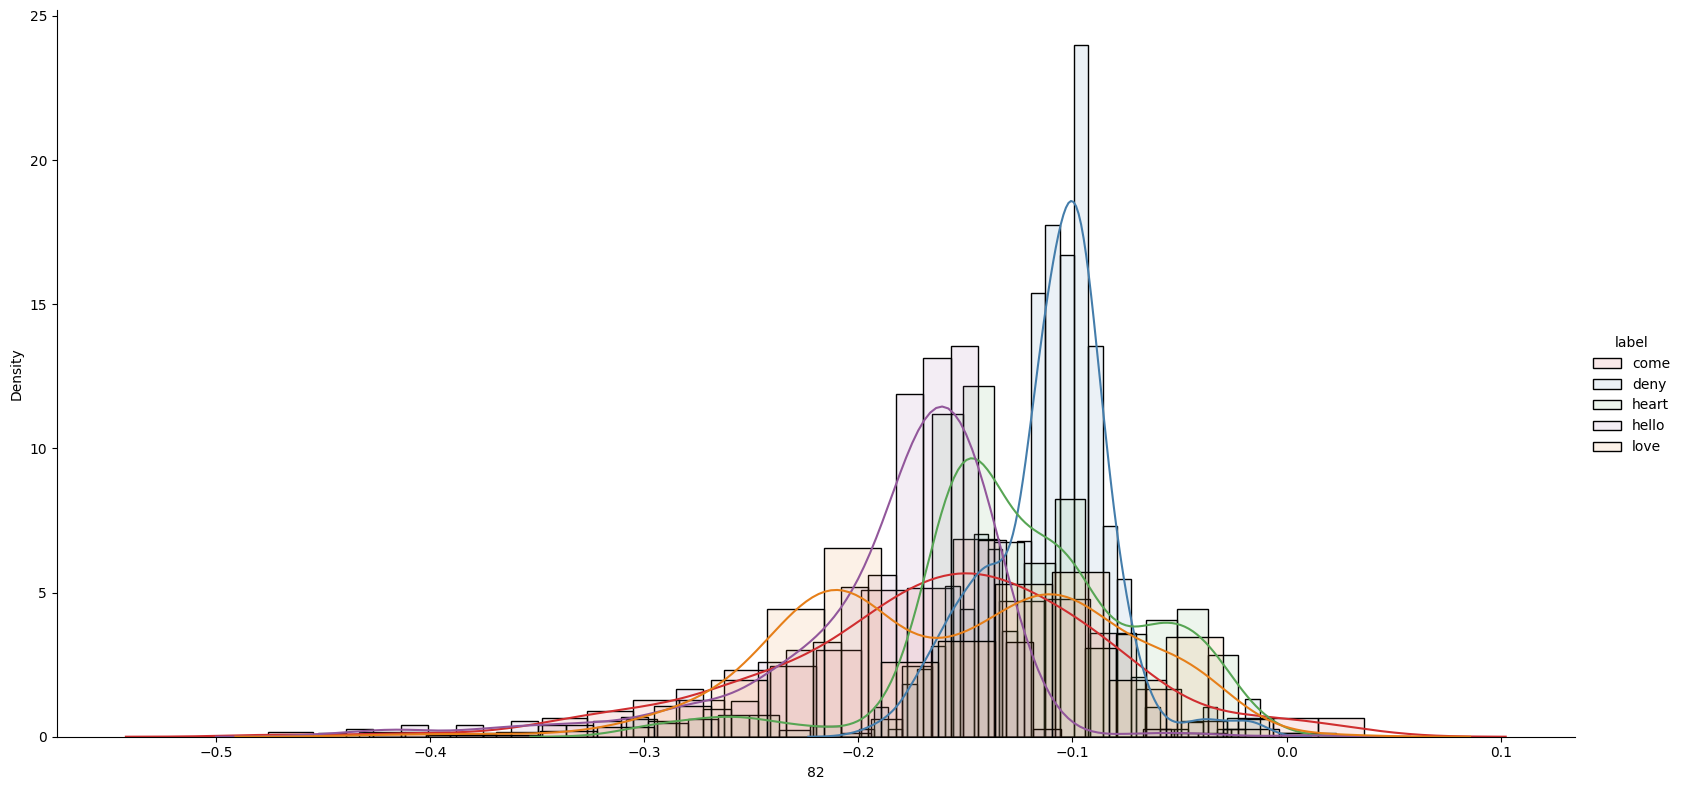

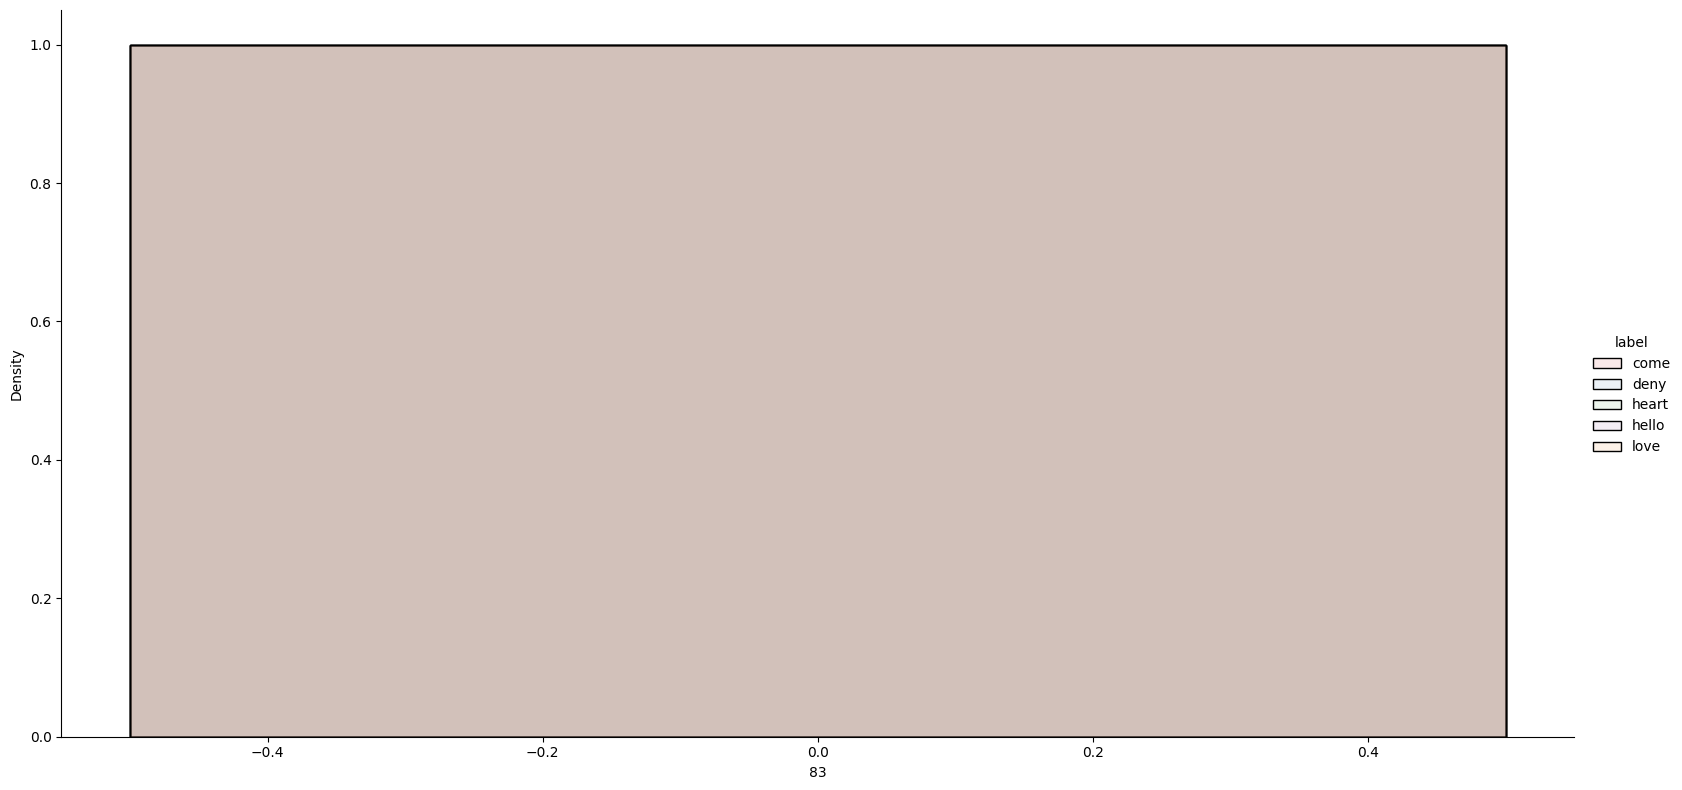

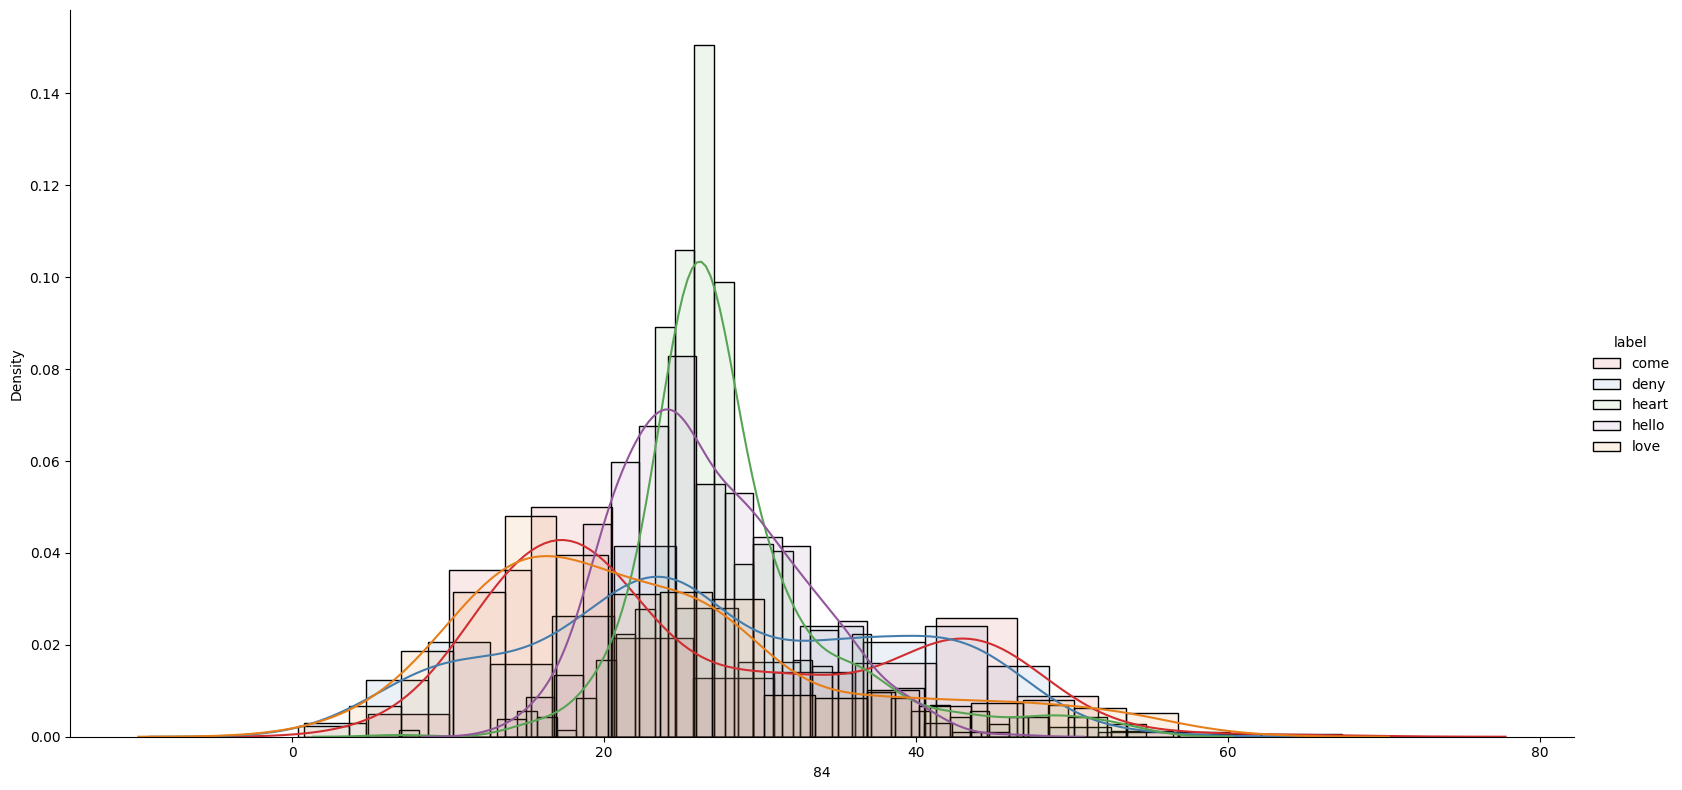

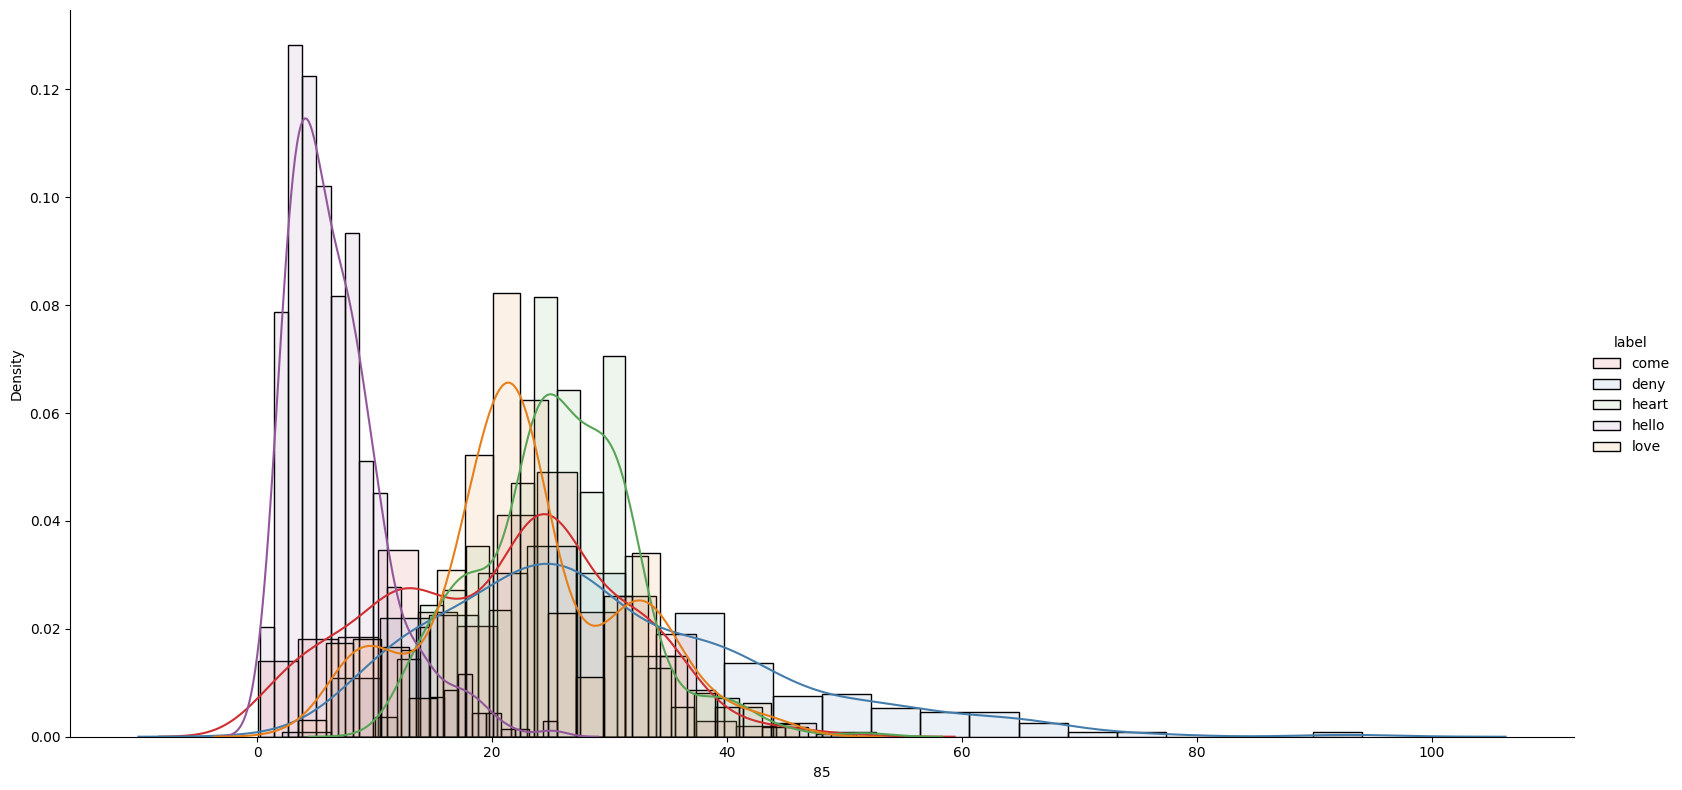

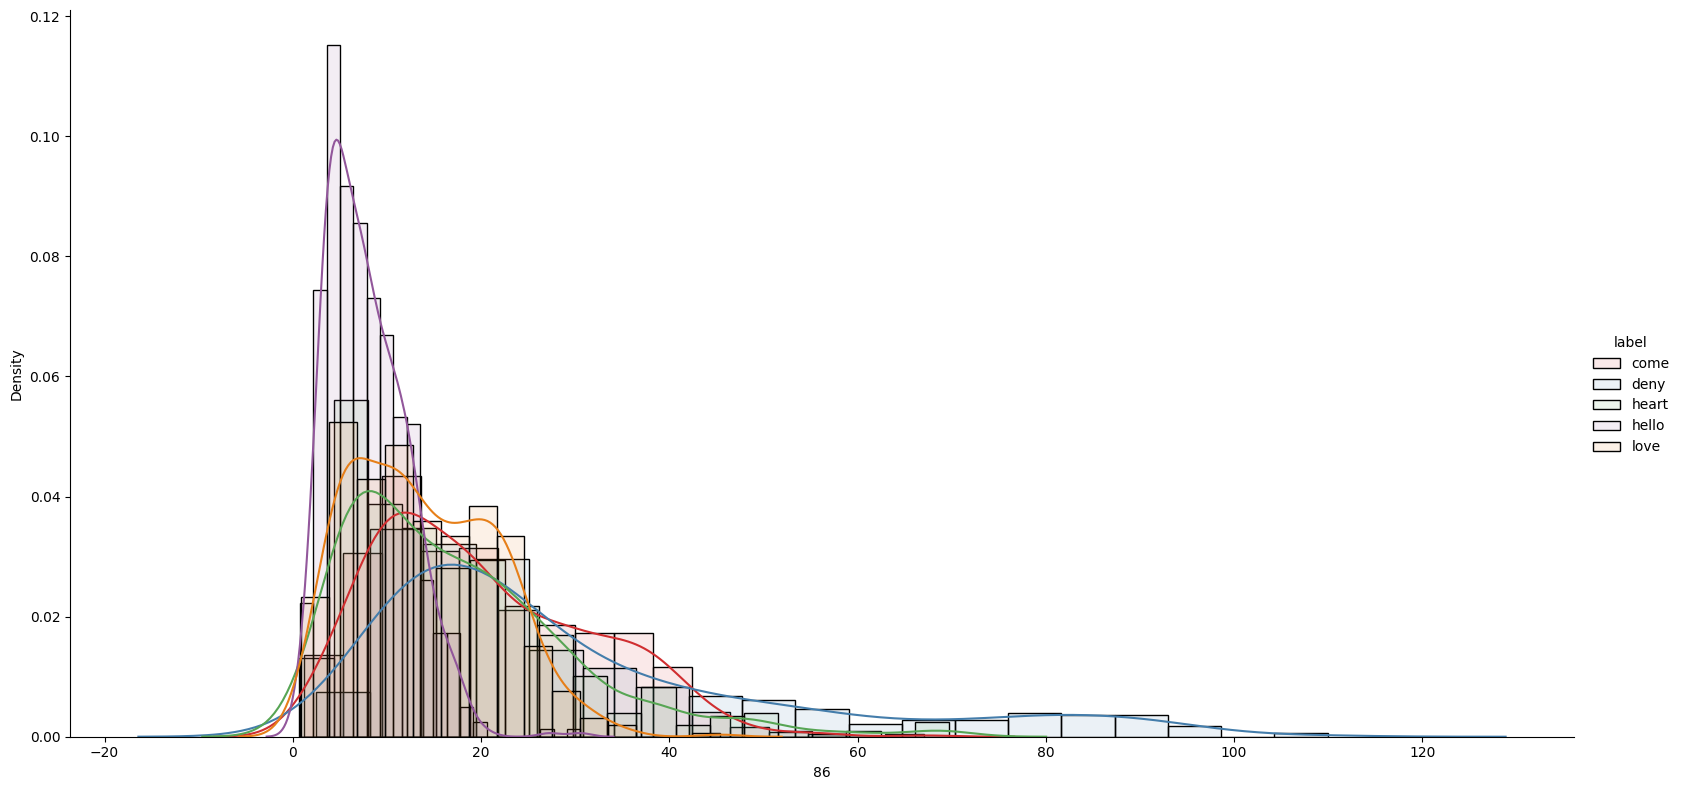

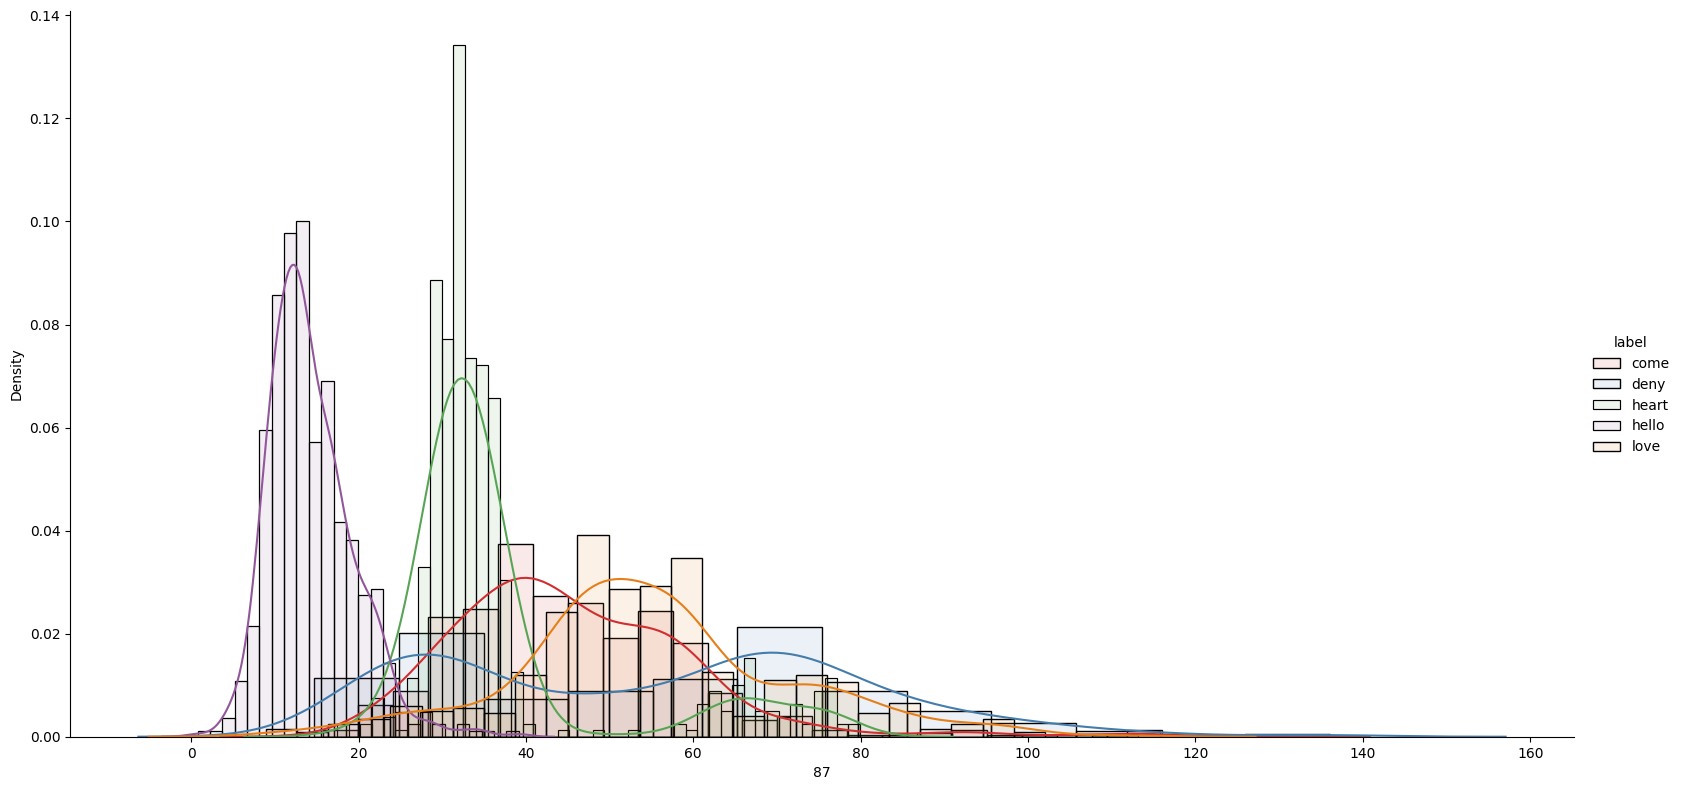

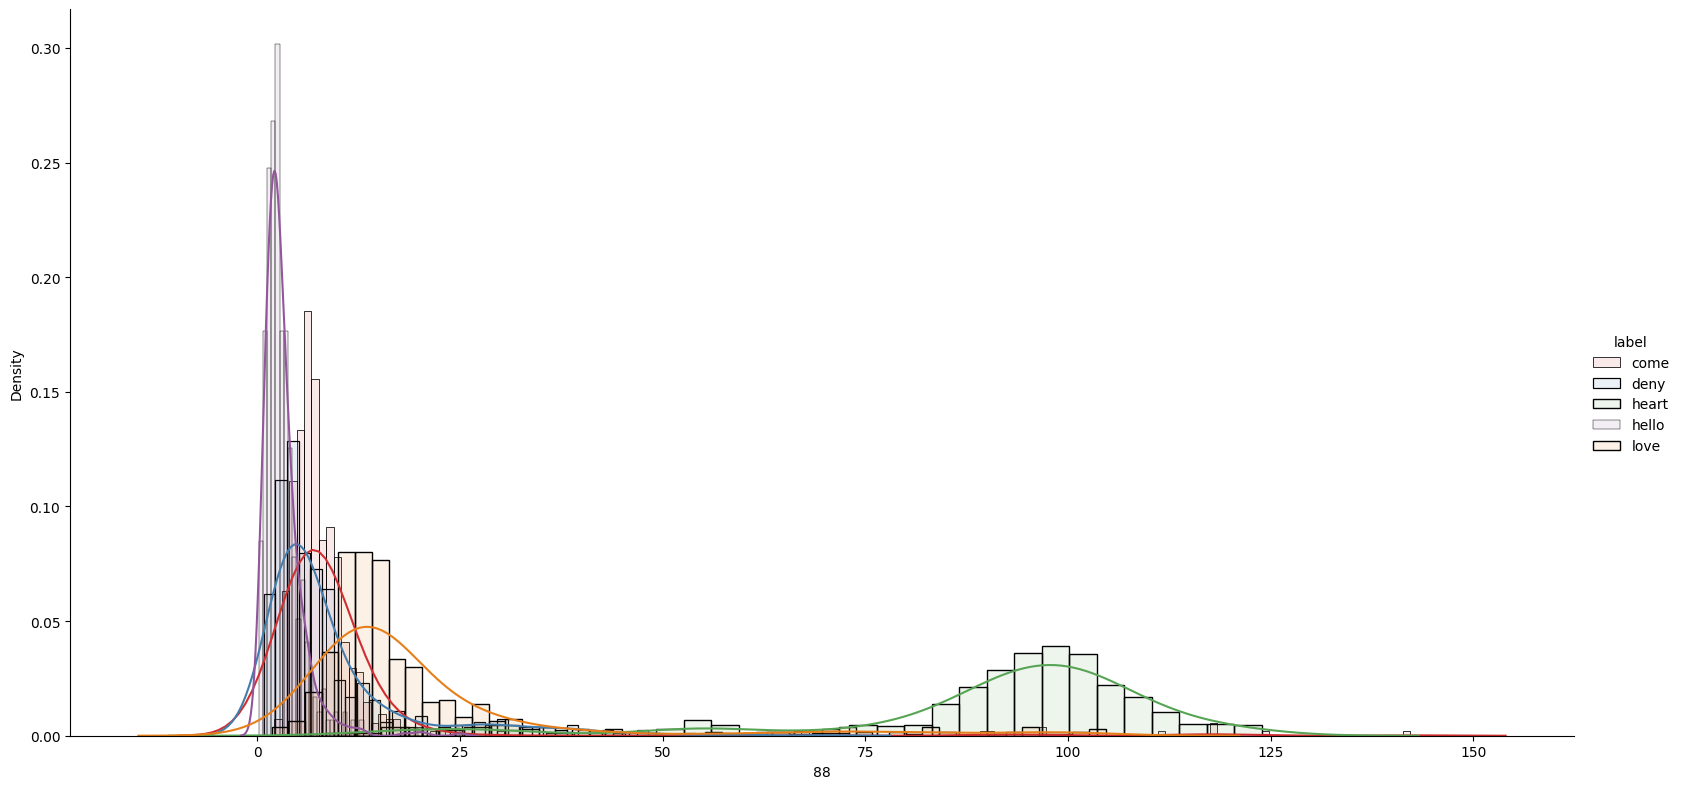

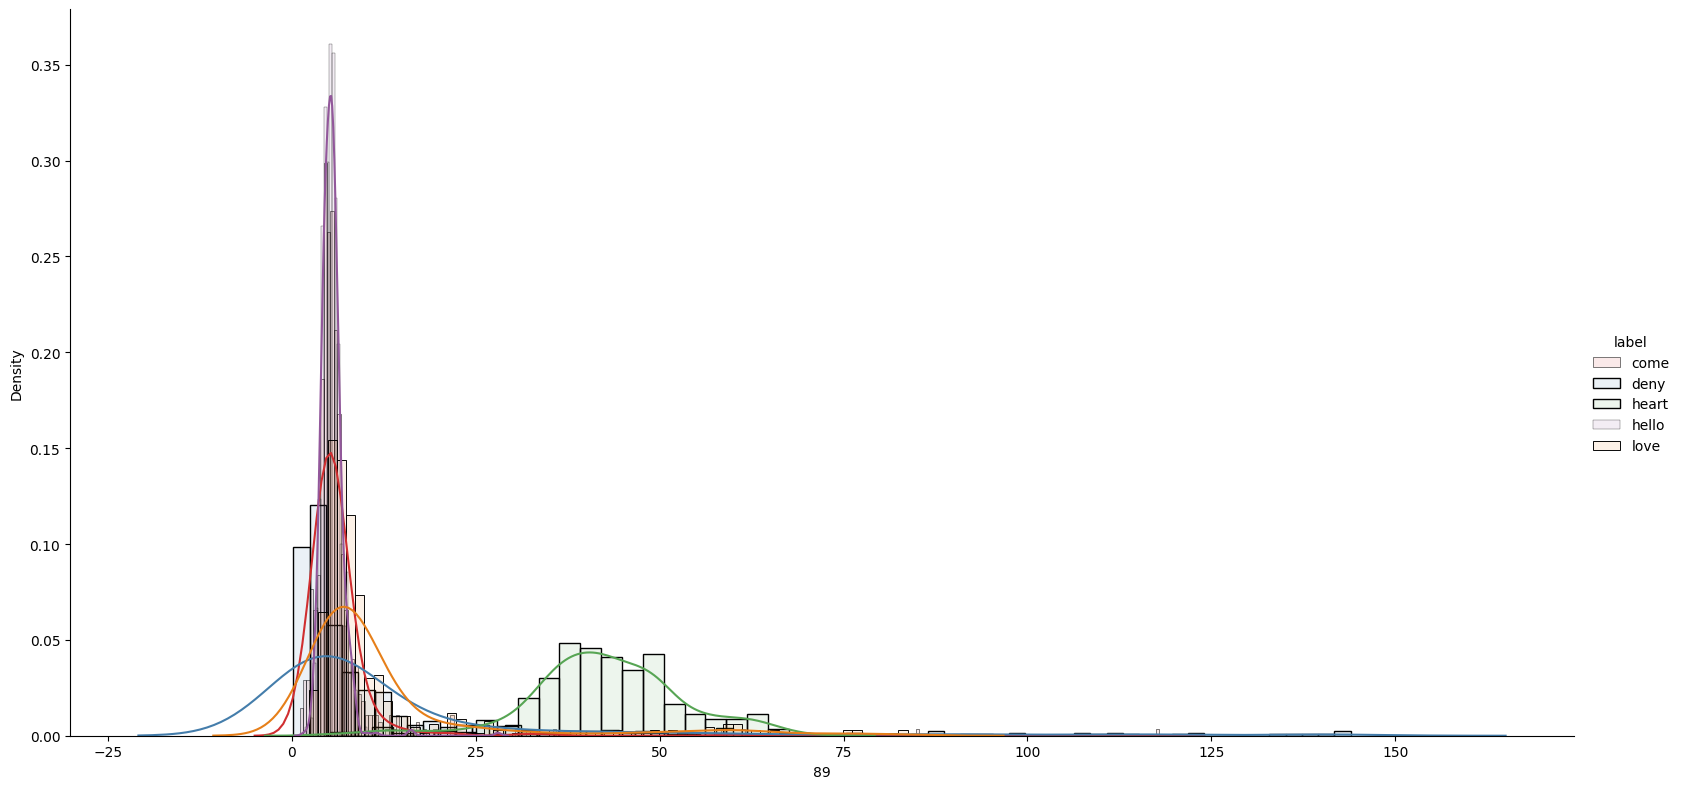

In [45]:
for i in range(80, 90):
    dist_sns(i)